In [6]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow.keras as keras
from time import time

In [7]:
# --- Paths ---
# Para Colab: descomenta estas dos líneas
'''
from google.colab import drive
drive.mount('/content/drive')
h5_file = '/content/drive/MyDrive/data/Galaxy10_DECals_NoDuplicated.h5'
'''
h5_file = os.path.join("data", "Galaxy10_DECals_NoDuplicated.h5")

In [8]:
# --- Cargar HDF5 para estadísticas y visualización ---
# Abrimos HDF5 una sola vez y mantenemos el handle abierto
h5 = h5py.File(h5_file, "r")
N = h5["images"].shape[0]
print("Total imágenes:", N)

# Solo cargamos las etiquetas y datos tabulares en RAM (son mucho más pequeños)
labels = h5["ans"][:]
redshift = h5["redshift"][:]
pxscale = h5["pxscale"][:]

Total imágenes: 17675


In [9]:
tipos_galaxia = {
    0: "spiral",
    1: "elliptical",
    2: "lenticular",
    3: "irregular",
    4: "merger",
    5: "unknown",
    6: "barred spiral",
    7: "compact",
    8: "edge-on",
    9: "uncertain"
} #el dataset no ofrece la equivalencia y las etiquetas solo son numeros, por eso recurrimos a la docuentación oficial del dataset para hacer la lista manualmente

In [10]:
#Division train/test/validación

indices = np.arange(N)
np.random.seed(42)
np.random.shuffle(indices)

train_end = int(0.7 * N)
val_end   = int(0.85 * N)

train = indices[:train_end]
val   = indices[train_end:val_end]
test  = indices[val_end:]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

train_labels = labels[train]

Train: 12372, Val: 2651, Test: 2652


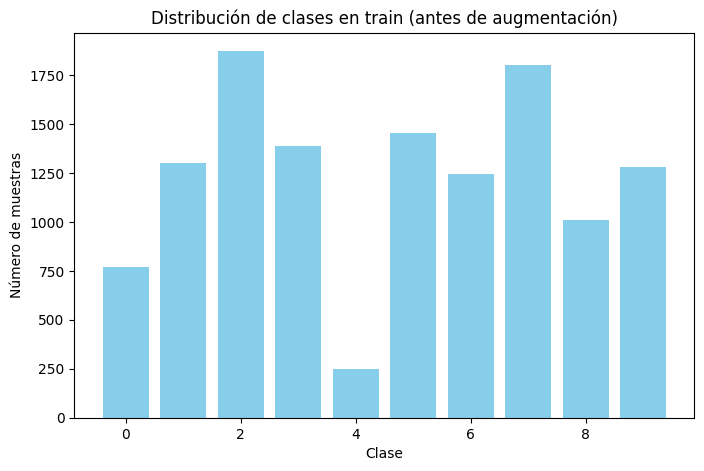

In [11]:
# --- Contar muestras por clase y Crear el gráfico de barras ---
train_labels = labels[train]
classes, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8,5))
plt.bar(classes, counts, color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases en train (antes de augmentación)")
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
val_datagen = ImageDataGenerator()  # solo normalización

# Calculamos factores de augmentación por clase para balancear minoritarias
unique_classes, counts = np.unique(train_labels, return_counts=True)
max_count = counts.max()
augment_factors = {c: int(np.ceil(max_count/count)) for c, count in zip(unique_classes, counts)}

# calculamos el número de imágenes final tras augmentación
simulated_counts = [counts[i] * augment_factors[c] for i, c in enumerate(classes)]
print("Factores de augmentación por clase:", augment_factors)

def create_balanced_generator(indices, datagen, batch_size=32):
    # --- 1. Agrupar índices por clase ---
    from collections import defaultdict
    class_indices = defaultdict(list)
    for idx in indices:
        lbl = labels[idx]
        class_indices[lbl].append(idx)

    # --- 2. Calcular cuántas clases hay y cuántas por batch ---
    unique_classes = list(class_indices.keys())
    n_classes = len(unique_classes)
    per_class = max(1, batch_size // n_classes)

    while True:
        batch_images, batch_tab, batch_labels = [], [], []

        for c in unique_classes:
            # Tomar 'per_class' indices aleatorios de cada clase
            idxs = np.random.choice(class_indices[c], size=per_class, replace=True)

            for idx in idxs:
                img = h5["images"][idx].astype(np.float32)
                img = tf.image.resize(img, [200, 200]).numpy()  # redimensiona a 200x200
                img /= 255.0
                tab = np.array([redshift[idx], pxscale[idx]], dtype=np.float32)
                lbl = labels[idx]
                img_aug = datagen.random_transform(img) if datagen else img

                batch_images.append(img_aug)
                batch_tab.append(tab)
                batch_labels.append(lbl)

                if len(batch_images) == batch_size:
                    yield {'img': np.array(batch_images, dtype=np.float32),
                           'tab': np.array(batch_tab, dtype=np.float32)}, np.array(batch_labels, dtype=np.int32)
                    batch_images, batch_tab, batch_labels = [], [], []


# Generadores
train_gen = create_balanced_generator(train, train_datagen, batch_size=batch_size)
val_gen   = create_balanced_generator(val, val_datagen, batch_size=batch_size)
test_gen  = create_balanced_generator(test, val_datagen, batch_size=batch_size)

Factores de augmentación por clase: {np.uint8(0): 3, np.uint8(1): 2, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 8, np.uint8(5): 2, np.uint8(6): 2, np.uint8(7): 2, np.uint8(8): 2, np.uint8(9): 2}


In [13]:
#comprobamos si nuestra generacion de imagenes para clases minoritarias a corregido el desbalanceo

# --- Visualización de balance final en train ---
import collections

all_labels = []
num_batches = 20  # suficiente para comprobar balanceo

gen_iter = iter(train_gen)
for _ in range(num_batches):
    _, y_batch = next(gen_iter)
    all_labels.extend(y_batch)

balanced_counts = collections.Counter(all_labels)

plt.figure(figsize=(8,5))
plt.bar(list(balanced_counts.keys()), list(balanced_counts.values()), color='skyblue')
plt.xlabel("Clase")
plt.ylabel("Número de muestras (aprox.)")
plt.title("Distribución de clases en train (muestra rápida)")
plt.show()

KeyboardInterrupt: 

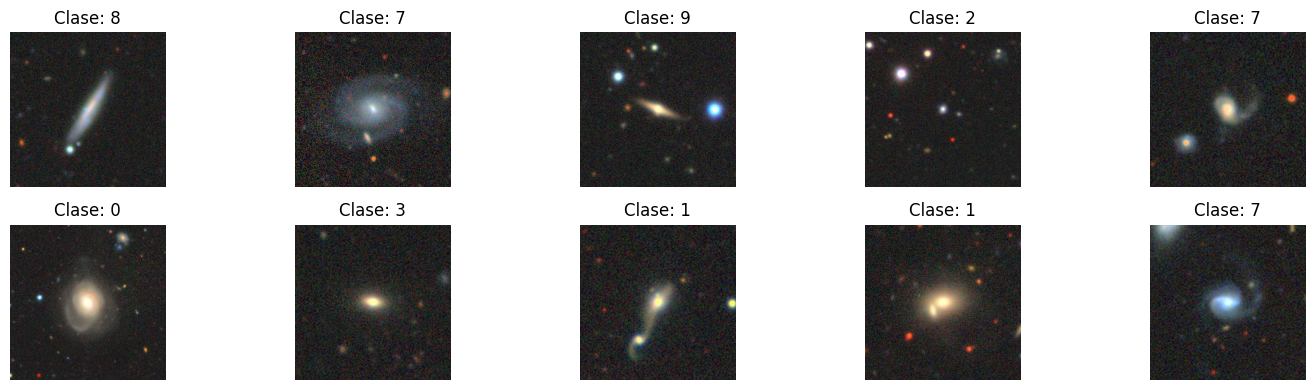

In [ ]:
#visualizamos las primeras 10 imagenes del train
plt.figure(figsize=(15,4))
for i, idx in enumerate(train[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(h5["images"][idx].astype(np.float32)/255.0)
    plt.title(f"Clase: {labels[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Bloque CNN de transfer learning con EfficientNetB0

img_input = Input(shape=(200,200,3), name="img")
tab_input = Input(shape=(2,), name="tab")

base_cnn = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=img_input)
base_cnn.trainable = False

x = layers.GlobalAveragePooling2D()(base_cnn.output)
x = layers.Dense(256, activation="relu")(x)

t = layers.Dense(32, activation="relu")(tab_input)
t = layers.BatchNormalization()(t)
t = layers.Dense(16, activation="relu")(t)

combined = layers.concatenate([x,t])
combined = layers.Dense(128, activation="relu")(combined)
combined = layers.Dense(64, activation="relu")(combined)
output = layers.Dense(10, activation="softmax")(combined)

model = Model(inputs=[img_input, tab_input], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ img[0][0]         │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,422,109 (16.87 MB)

 Trainable params: 372,474 (1.42 MB)

 Non-trainable params: 4,049,635 (15.45 MB)

In [ ]:
# --- Bloque de prueba rápido antes de entrenamiento completo ---

# --- Test rápido para comprobar NaNs antes del entrenamiento completo ---
batch_size_test = 8
test_gen_check = create_balanced_generator(train, datagen=None, batch_size=batch_size_test)

for i in range(3):  # 3 batches
    X_batch, y_batch = next(test_gen_check)
    loss, acc = model.train_on_batch(X_batch, y_batch)
    print(f"Batch {i+1} -> loss: {loss:.6f}, accuracy: {acc:.6f}")

preds = model.predict(X_batch)
if np.isnan(preds).any():
    print("⚠️ Predicciones contienen NaN")
else:
    print("✅ Predicciones correctas, sin NaN")


Batch 1 -> loss: 2.296097, accuracy: 0.125000
Batch 2 -> loss: 2.311902, accuracy: 0.125000
Batch 3 -> loss: 2.301318, accuracy: 0.125000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Predicciones correctas, sin NaN


In [15]:
#entrenamiento

from tensorflow.keras.callbacks import EarlyStopping
from time import time

earlyS = EarlyStopping(patience=5, restore_best_weights=True)

steps_per_epoch = len(train)//batch_size
validation_steps = len(val)//batch_size

t0 = time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[earlyS]
)
print("Tiempo de entrenamiento:", round(time()-t0,2))

Epoch 1/15
  4/386 ━━━━━━━━━━━━━━━━━━━━ 2:44:59 26s/step - accuracy: 0.0703 - loss: 2.4489

KeyboardInterrupt: 

In [ ]:
#evaluacion en test

y_true, y_pred = [], []
steps_test = len(test)//batch_size

for X_batch, y_batch in test_gen:
    preds = model.predict(X_batch)
    y_pred_batch = np.argmax(preds, axis=1)
    y_true.extend(y_batch)
    y_pred.extend(y_pred_batch)
    if len(y_true) >= len(test):
        break

inverse_map = {v:k for k,v in tipos_galaxia.items()}
y_true_labels = [inverse_map[y] for y in y_true]
y_pred_labels = [inverse_map[y] for y in y_pred]

print(classification_report(y_true_labels, y_pred_labels))
ConfusionMatrixDisplay.from_predictions(y_true_labels, y_pred_labels, normalize="true", cmap="Blues")